In [5]:
import sys
sys.path.insert(1, '../')


In [6]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciii_sepsis/../medical_explainer.py'>

In [8]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [9]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)


In [11]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)

<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciii_sepsis/../medical_explainer.py'>

| Step 1  ==> Calibrating model


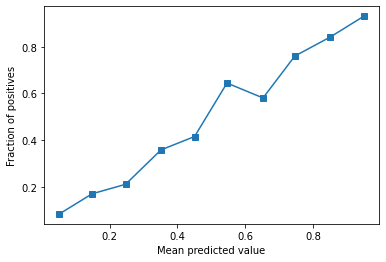

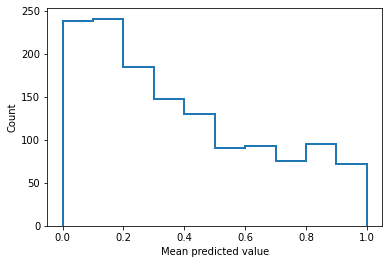

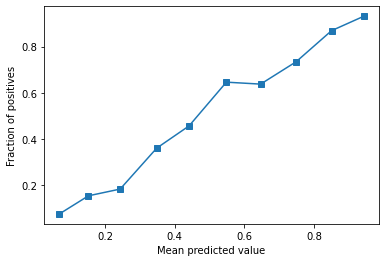

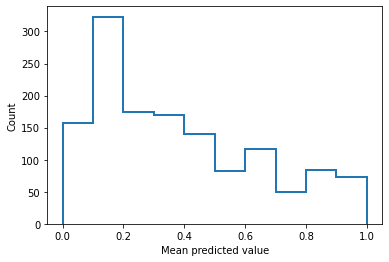

ROC AUC: 0.8157752847679719
Average Precision: 0.75387635987988
Accuracy: 0.7688368690563278
ROC AUC: 0.8177349052585793
Average Precision: 0.7562333607064786
Accuracy: 0.7666422823701536

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 10.0

Probability threshold: 0.5
Score threshold: 22.0

Probability threshold: 0.9
Score threshold: 34.0



In [12]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')

In [13]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.6936105044720127
Average Precision: 0.563396083304583
Accuracy: 0.6664228237015362
[[700 144]
 [312 211]]


In [15]:
explainer.shap_array_list

[[0.4686421950271874, -0.974145777145089],
 [-0.4402025530575534, 0.4123430952616316],
 [-0.4161156643454893, 0.3579333868086614],
 [-0.4218811786304235, 0.3403209556682654],
 [-0.29059041430216676, 0.30626477219835074],
 [0.26267104975191624, -0.2666927073433015],
 [0.26258109781063843, -0.25398121983228594],
 [-0.17281635676667492, 0.4319058925732142],
 [-0.18345886381665902, 0.5095108647480542],
 [-0.18863234355688566, 0.29474105854628657]]

In [16]:
explainer.score_array_list

[array([ 2., -5.]),
 array([-2.,  2.]),
 array([-2.,  2.]),
 array([-2.,  2.]),
 array([-2.,  2.]),
 array([ 1., -1.]),
 array([ 1., -1.]),
 array([-1.,  2.]),
 array([-1.,  3.]),
 array([-1.,  2.])]

In [17]:
explainer.variables

array(['LOS', 'inotropes', 'Age', 'Bicarbonate', 'Chloride', 'Albumin',
       'Sodium', 'ICU_LOS', 'Bilirubin, Indirect', 'RDW'], dtype=object)

In [18]:
explainer.breakpoints_list

[[-0.3222222222222222, 15.512576648669134, 294.66041666666666],
 [0.0, 0.6575509937319135, 3.0],
 [18.258726899383984, 67.27633115541632, 90.0],
 [0.0, 22.718756067499843, 42.0],
 [74.0, 102.63850919523638, 140.0],
 [0.0, 2.9636059817287377, 18.290282613036652],
 [104.0, 138.3833302738175, 174.0],
 [0.008, 7.44812867935562, 153.928],
 [-35.022535874913956, 1.3292468407404754, 17.9],
 [11.6, 15.637431995363887, 30.5]]

In [19]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.6936105044720127
Average Precision: 0.563396083304583
Accuracy: 0.6664228237015362
[[700 144]
 [312 211]]


In [21]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [23]:
y_test = y_test.reset_index(drop=True)

In [24]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.6978450005279274, 0.688280936411151, 0.7074090646447039)
(0.5766082074508388, 0.5648766701579107, 0.588339744743767)
(0.6689999999999999, 0.6618000156463995, 0.6761999843536004)
